In [11]:
dut.disconnect()

Serial port disconnected.


In [96]:
dut.ground_PIC()

DAC initialized to a span from -5 V to 5 V


In [95]:
dut.reset_chip()
dut.reset_dpe()

In [94]:
dut.power_off()

In [76]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

# dut.drv.serUSB = 'COM19'
drv = dut.drv

ser = serial.Serial('COM6', 9600, timeout=1)
dut.connect(ser)


In [97]:
dut.power_on()

In [98]:
drv.gpio_pin_set('H', 1)

Calibrate all 12 ADCs on A0

In [127]:
volt_in = np.arange(0.44, 4.0, 0.01)
volt_out_list = []

adc_raw=[]
for addr_fifo in range(12):
    print(addr_fifo, end='->')
    data = dut.calibrate_adc(volt_in, addr_fifo=addr_fifo )
    volt_out_list.append( [dut.adc2volt(d) for d in data] )
    adc_raw.append(data)

0->1->2->3->4->5->6->7->8->9->10->11->

Text(0, 0.5, 'Quality number')

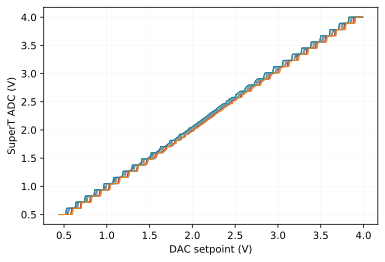

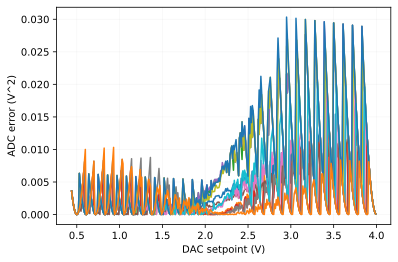

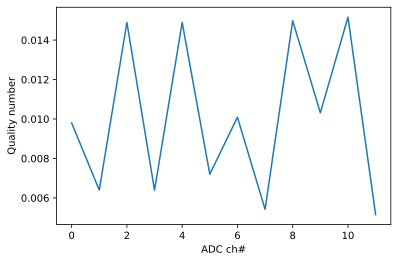

In [128]:
volt_out_list = np.array(volt_out_list)

adc_quality = []

plt.figure(1)
plt.xlabel('DAC setpoint (V)')
plt.ylabel('SuperT ADC (V)')
plt.grid(True, alpha=0.1)

for i, volt_out in enumerate(volt_out_list):
    plt.figure(1)
    plt.plot(volt_in, volt_out, linewidth=1)
    
    voffset=0
    volt_err2 = []
    for vin, vout in zip(volt_in, volt_out):
        volt_err2.append( (vout-vin -voffset)**2 )
    volt_err2 = np.array(volt_err2)
    adc_quality.append( (np.max(volt_err2) - np.min(volt_err2))/2 )
        
    plt.figure(2)
    plt.plot(volt_in, volt_err2)

plt.grid(True, alpha=0.1)
plt.xlabel('DAC setpoint (V)')
plt.ylabel('ADC error (V^2)')
    
plt.figure(3)
plt.plot(range(12), adc_quality)
plt.xlabel('ADC ch#')
plt.ylabel('Quality number')

In [81]:
volt_out_list = np.array(volt_out_list)

np.savetxt("adc_data_0.001.csv", volt_out_list.T, delimiter=",")
from lib_data import *
save_workspace(vars(), note='adc')

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), volt_in(<class 'numpy.ndarray'>), volt_out_list(<class 'numpy.ndarray'>), adc_raw(<class 'list'>), addr_fifo(<class 'int'>), data(<class 'list'>), volt_out(<class 'numpy.ndarray'>), i(<class 'int'>), n_adc(<class 'int'>), d(<class 'int'>), to 20190809-142113-adc.pkl
Saving In(<class 'list'>), volt_in(<class 'numpy.ndarray'>), volt_out_list(<class 'numpy.ndarray'>), adc_raw(<class 'list'>), addr_fifo(<class 'int'>), data(<class 'list'>), volt_out(<class 'numpy.ndarray'>), i(<class 'int'>), n_adc(<class 'int'>), d(<class 'int'>), to 20190809-142113-adc.mat


In [82]:
adc_raw=np.array(adc_raw)
np.savetxt("adc_raw_0.01.csv", adc_raw.T, delimiter=",")

In [83]:
volt_out_list = np.array(volt_out_list)
for i in range(12):
    np.savetxt(f"adc_data_{i}.csv", volt_out_list[i].T, delimiter=",")


In [84]:
drv.gpio_pin_reset(*PIC_PINS['READ_DPE'])
drv.gpio_pin_reset(*PIC_PINS['READ_BIT'])
dut.pads_defaults()

dut.scan_tia( BitArray('0b1100010000'*96).bytes )

dut.load_vectors_rows_to_zero()
dut.load_vectors_cols_to_zero()


drv.gpio_array_en_write(0b100)
drv.gpio_pin_set(*PIC_PINS['COL_ROW_SEL'])
drv.gpio_row_col_bank_write(0b0001)
drv.gpio_row_col_data_write(0b0001_0000_0000_0000)
time.sleep(1e-5)
drv.gpio_pin_set(*PIC_PINS['LATCH_CLK_DATA'])
time.sleep(1e-5)
drv.gpio_pin_reset(*PIC_PINS['LATCH_CLK_DATA'])

# data = dut.data_generate_sparse([0, 6])
# dut.load_vectors(array=2, data=data)

dut.reset_dpe()
# dut.py_logic_analyzer()

In [85]:
dut.reset_dpe()

drv.gpio_pin_set(*PIC_PINS['WRITE_SEL_EXT'])
drv.gpio_pin_set(*PIC_PINS['DPE_EXT_OVERRIDE_EN'])                 
time.sleep(5e-6)   
drv.gpio_nforce_safe_write(0b111)
time.sleep(5e-6)        # delay(t_cal_start), min = 2TCK
drv.gpio_pin_set(*PIC_PINS['COL_WRITE_CONNECT'])
time.sleep(5e-6)        # delay(t_opamp), min = 500ns
drv.gpio_pin_set(*PIC_PINS['CONNECT_TIA'])
#drv.gpio_pin_set(*PIC_PINS['DPE_EXT_SH'])

In [86]:
# Before setting this, we're using an external current source to apply to the board!
drv.gpio_pin_set(*PIC_PINS['DPE_EXT_SH'])

In [87]:
n_adc = 0

data = dut.download_fifo( n_adc )

for d in data:
    print(f'{d:013b} -> {dut.adc2volt(d):.3f}')
    
# drv.gpio_adc_fifo_en_write(n_adc)

# for strobe in range(15):
#     drv.gpio_pin_set(*PIC_PINS['ADC_FIFO_ADVANCE'])
#     drv.gpio_pin_reset(*PIC_PINS['ADC_FIFO_ADVANCE'])
#     data = drv.gpio_adc_read()
#     print(f'{data:013b}', end='\t')
#     #print(strobe)
#     print( f'{dut.adc2volt(data):.3f} V' )
# print()

1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500


In [88]:
for n_adc in range(12):
    data = dut.download_fifo( n_adc )

    print(f'fifo #{n_adc}')
    for d in data:
        print(f'{d:013b} -> {dut.adc2volt(d):.3f}')
    print()

fifo #0
1000000000000 -> 0.500
0001000000000 -> 2.252
0001000000000 -> 2.252
0001000000000 -> 2.252
0001000000000 -> 2.252
0001000000000 -> 2.252
0001000000000 -> 2.252
0001000000000 -> 2.252
0001000000000 -> 2.252
0001000000000 -> 2.252
0001000000000 -> 2.252
0001000000000 -> 2.252
0001000000000 -> 2.252
0001000000000 -> 2.252
0001000000000 -> 2.252
0001000000000 -> 2.252

fifo #1
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500

fifo #2
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
1000000000000 -> 0.500
10000000

---------NEW CALIBRATION WITH ZHAN'S MAPPING=---------

In [195]:
drv.gpio_pin_reset(*PIC_PINS['READ_DPE'])
drv.gpio_pin_reset(*PIC_PINS['READ_BIT'])
dut.pads_defaults()

dut.scan_tia( BitArray('0b1100000100'*96).bytes )

dut.load_vectors_rows_to_zero()
dut.load_vectors_cols_to_zero()



In [ ]:
drv.gpio_array_en_write(0b010)
drv.gpio_pin_set(*PIC_PINS['COL_ROW_SEL'])
drv.gpio_row_col_bank_write(0b0001)
drv.gpio_row_col_data_write(0b1000_0000_0000_0000)
time.sleep(1e-5)
drv.gpio_pin_set(*PIC_PINS['LATCH_CLK_DATA'])
time.sleep(1e-5)
drv.gpio_pin_reset(*PIC_PINS['LATCH_CLK_DATA'])

dut.reset_dpe()

In [162]:
drv.gpio_pin_reset(*PIC_PINS['READ_DPE'])
drv.gpio_pin_reset(*PIC_PINS['READ_BIT'])
dut.pads_defaults()

dut.scan_tia( BitArray('0b1100000100'*96).bytes )

data = dut.data_generate_sparse([59, 5, 59, 7])
dut.load_vectors(array=2, data=data)

1
0
2
12288
4
0
8
0


In [143]:
dut.py_logic_analyzer()

1 	PWR_GOOD
1 	NRESET_FULL_CHIP
1 	NRESET_DPE_ENGINE
0 	ARRAY_EN<0>
0 	ARRAY_EN<1>
0 	ARRAY_EN<2>
0 	NFORCE_SAFE0
0 	NFORCE_SAFE1
0 	NFORCE_SAFE2
0 	ADC_SEL_EXT
0 	DPE_EXT_OVERRIDE_EN
0 	DPE_EXT_SH
1 	ADC_DONE
0 	ADC_FIFO_ADVANCE
0 	ADC_FIFO_EN<0>
0 	ADC_FIFO_EN<1>
0 	ADC_FIFO_EN<2>
0 	ADC_FIFO_EN<3>


Read test

In [493]:
def _read(Vread, Vgate, array=0, row=0, col=0):
    dut.scan_control(scan_ctrl_bits=bytes([0x10, 0x02, 0x0c, 0x10,
                                           0x20, 0x01, 0x02]))
#     dut.scan_tia( BitArray('0b1111100010'*96).bytes )
#     dut.scan_tia( BitArray('0b1101000100'*96).bytes )
    dut.scan_tia( BitArray('0b1100001000'*96).bytes )
    dut.dac_set('PLANE_VPP', Vread)
    dut.dac_set('P_VREF_TIA', 0.5)
    dut.dac_set('P_TVDD', Vgate)

    data_load = dut.data_generate_sparse([row, col])
    dut.load_vectors(array=array, data=data_load)

    ################LOAD VECTOR REPLACEMENT############
#     drv.gpio_array_en_write(0b100)
#     drv.gpio_pin_set(*PIC_PINS['COL_ROW_SEL'])
#     drv.gpio_row_col_bank_write(0b0001)
#     drv.gpio_row_col_data_write(0b1000_0000_0000_0000)
#     time.sleep(1e-5)
#     drv.gpio_pin_set(*PIC_PINS['LATCH_CLK_DATA'])
#     time.sleep(1e-5)
#     drv.gpio_pin_reset(*PIC_PINS['LATCH_CLK_DATA'])

#     drv.gpio_array_en_write(0b100)
#     drv.gpio_pin_reset(*PIC_PINS['COL_ROW_SEL'])
#     drv.gpio_row_col_bank_write(0b0001)
#     drv.gpio_row_col_data_write(0b0100_0000_0000_0000)
#     time.sleep(1e-5)
#     drv.gpio_pin_set(*PIC_PINS['LATCH_CLK_DATA'])
#     time.sleep(1e-5)
#     drv.gpio_pin_reset(*PIC_PINS['LATCH_CLK_DATA'])
    ################END LOAD VECTOR REPLACEMENT########

    dut.pads_defaults()

    dut.reset_dpe()

    # drv.gpio_pin_set(*PIC_PINS['DPE_INTERNAL_EN'])

    drv.gpio_pin_set(*PIC_PINS['DPE_EXT_OVERRIDE_EN'])
    drv.gpio_pin_set(*PIC_PINS['READ_BIT'])
    drv.gpio_pin_reset(*PIC_PINS['READ_DPE'])

    drv.gpio_nforce_safe_write(0b100)
    drv.gpio_pin_set(*PIC_PINS['CONNECT_TIA'])
    drv.gpio_pin_set(*PIC_PINS['CONNECT_COLUMN_T'])

    # drv.gpio_pin_set(*PIC_PINS['DPE_PULSE'])
    # drv.gpio_pin_reset(*PIC_PINS['DPE_PULSE'])

    drv.gpio_pin_set(*PIC_PINS['DPE_EXT_PULSE'])
    time.sleep(0.01)
    drv.gpio_pin_set(*PIC_PINS['DPE_EXT_SH'])
    
    [fifo_en, channel] = dut.which_fifo([array, row, col])

    data = dut.download_fifo( fifo_en )
    volt = dut.adc2volt(data[channel])
    
    return volt
    

In [8]:
Vreads = np.arange(0.46,0.51,0.001)
Vgates = np.arange(4.5,5,0.5)

volts_set = []

for Vgate in Vgates:
    print(f'{Vgate:.2f}', end='-')
    volts = []
    for vread in Vreads:
        volts.append( _read(vread, Vgate, array=2, row=29, col=0 ) )
    volts_set.append(volts)

4.50-

NameError: name '_read' is not defined

In [ ]:
for volts in volts_set:
    plt.plot(Vreads, [v/30e3 * 1e6 for v in volts], '.-')
    
plt.xlabel('VPP')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)

In [379]:
[fifo_en, channel] = dut.which_fifo([2, 31, 0])
print(fifo_en, channel)

0 7


In [ ]:
for n_adc in [0,1,6,7]:

    data = dut.download_fifo( n_adc )

    print(f'fifo #{n_adc}')
    for d in data:
        print(f'{d:013b} -> {dut.adc2volt(d):.3f}')
    print()

In [ ]:
for n_adc in [0,1,6,7]:

    data = dut.download_fifo( n_adc )

    print(f'fifo #{n_adc}')
    for d in data:
        print(f'{d:013b} -> {dut.adc2volt(d):.3f}')
    print()

In [45]:
# for n_adc in range(12):
n_adc = 0

data = dut.download_fifo( n_adc )

print(f'fifo #{n_adc}')
for d in data:
    print(f'{d:013b} -> {dut.adc2volt(d):.3f}')
print()

n_adc = 11

data = dut.download_fifo( n_adc )

print(f'fifo #{n_adc}')
for d in data:
    print(f'{d:013b} -> {dut.adc2volt(d):.3f}')
print()

fifo #0
0110000000000 -> 0.500
0110000000000 -> 0.500
0110000000000 -> 0.500
0110101001000 -> 1.622
0110000000000 -> 0.500
0110000000000 -> 0.500
0110000000000 -> 0.500
0110000000000 -> 0.500
0110000000000 -> 0.500
0110000000000 -> 0.500
0110000000000 -> 0.500
0110001001000 -> 0.746
0110010100000 -> 1.047
0110000000000 -> 0.500
0110000000000 -> 0.500
0110000000000 -> 0.500

fifo #11
0110000000000 -> 0.500
0110000000000 -> 0.500
0110000000000 -> 0.500
0110000000000 -> 0.500
0110000000000 -> 0.500
0110010000000 -> 0.938
0110100000000 -> 1.376
0110000100000 -> 0.609
0110000000000 -> 0.500
0110010000000 -> 0.938
0110000000000 -> 0.500
0110000000000 -> 0.500
0110000100000 -> 0.609
0110011000000 -> 1.157
0110000000000 -> 0.500
0110000000000 -> 0.500



In [67]:
Vreads = np.arange(0, 0.5, 0.01)
# Vgates = np.arange(0,5,0.5)
# Vgates = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 5]
Vgates = [5]

volts_set = []

for Vgate in Vgates:
    print(f'{Vgate:.2f}', end='-')
    volts = []
    for vread in Vreads:
        volts.append( a0.read_single(vread, Vgate, array=2, row=31, col=0, gain=2) )
    volts_set.append(volts)

5.00-

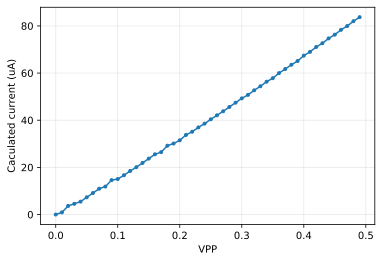

In [68]:
for volts in volts_set:
    plt.plot(Vreads, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('VPP')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)
# plt.ylim(-0.1, 6)

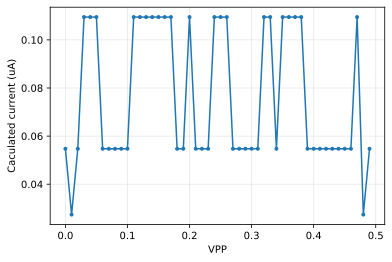

In [81]:
for volts in volts_set:
    plt.plot(Vreads, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('VPP')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)
# plt.ylim(-0.1, 6)

In [87]:
Vread1 = 0.1
Vread2 = 0.2

Vgate = 5

Gmap_all = []

for ar in [1]:
    Gmap = []

    for r in range(16):
        if r%5 ==0:
            print(f'r={r}, ')
        Grow = []
        for c in range(16):
    #         print(f'{c}', end=',')
            v1 = a0.read_single(Vread=Vread1, Vgate=Vgate, array=ar, row=r, col=c, gain=2)
            v2 = a0.read_single(Vread=Vread2, Vgate=Vgate, array=ar, row=r, col=c, gain=2)
            Grow.append( (v2-v1) / 0.1 )
        Gmap.append(Grow)
#     print()
    
    Gmap_all.append(Gmap)

r=0, 
r=5, 
r=10, 
r=15, 


Text(0.5, 1.0, 's')

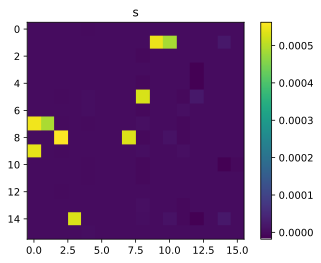

In [88]:
plt.imshow(Gmap)
plt.colorbar()
plt.title(f's')
# plt.clim(0,8e-7)

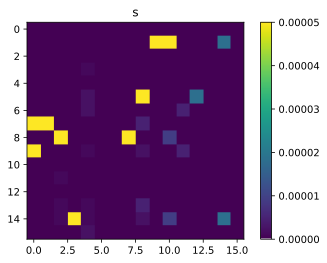

In [91]:
plt.imshow(Gmap)
plt.colorbar()
plt.title(f's')
plt.clim(0, 5e-5)

In [564]:
from lib_data import *

save_workspace(vars(), note='Gmap_all')

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), addr_fifo(<class 'int'>), volt_in(<class 'numpy.ndarray'>), data(<class 'list'>), volt_out(<class 'list'>), Vread(<class 'float'>), Vgate(<class 'int'>), n_adc(<class 'int'>), d(<class 'int'>), volt(<class 'float'>), volts(<class 'list'>), vread(<class 'numpy.float64'>), Vreads(<class 'numpy.ndarray'>), Vgates(<class 'numpy.ndarray'>), volts_set(<class 'list'>), volt_out_list(<class 'list'>), data_load(<class 'list'>), fifo_en(<class 'int'>), channel(<class 'int'>), Vread1(<class 'float'>), Vread2(<class 'float'>), Gmap(<class 'list'>), r(<class 'int'>), Grow(<class 'list'>), c(<class 'int'>), v1(<class 'float'>), v2(<class 'float'>), Gmap_all(<class 'list'>), ar(<class 'int'>), to 20190802-134257-Gmap_all.pkl
Saving In(<class 'list'>), addr_fifo(<class 'int'>), volt_in(<class 'numpy.ndarray'>), data(<class 'list'>), volt_out(<class 'list'

In [565]:
Gmap_all_new =  np.array(Gmap_all)

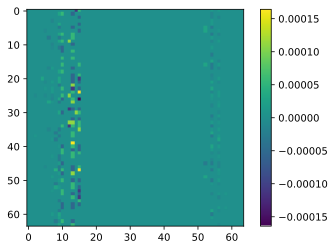

In [574]:
plt.imshow(Gmap_all_new[0])
plt.colorbar()

In [573]:
np.min(Gmap_all_new[0])

-0.00010948191593352896

In [586]:
r=0
c=15
ar = 0
Vgate = 5

v1 = a0.read_single(Vread=Vread1, Vgate=Vgate, array=ar, row=r, col=c, gain=4)
v2 = a0.read_single(Vread=Vread2, Vgate=Vgate, array=ar, row=r, col=c, gain=4)
g = (v2-v1)/1e6 / 0.1 


print(g)

0.0


Single read

In [72]:
Vread = 0.2

Vgate = 5
gain_list = range(5)

Gmap_all = []

for gain in gain_list:
    Gmap = []

    for r in range(16):
        if r%5 ==0:
            print(f'r={r}, ')
        Grow = []
        for c in range(16):
            curr = a0.read_single(Vread=Vread, Vgate=Vgate, array=1, row=r, col=c, gain=gain)
            Grow.append( curr / Vread )
        Gmap.append(Grow)
    
    Gmap_all.append(Gmap)

r=0, 
r=5, 
r=10, 
r=15, 
r=0, 
r=5, 
r=10, 
r=15, 
r=0, 
r=5, 
r=10, 
r=15, 
r=0, 
r=5, 
r=10, 
r=15, 
r=0, 
r=5, 
r=10, 
r=15, 


In [73]:
from lib_data import *
save_workspace(vars(), note='gains')

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), volt_in(<class 'numpy.ndarray'>), volt_out_list(<class 'list'>), addr_fifo(<class 'int'>), data(<class 'list'>), volt_out(<class 'list'>), n_adc(<class 'int'>), d(<class 'int'>), Vreads(<class 'numpy.ndarray'>), Vgates(<class 'list'>), volts_set(<class 'list'>), Vgate(<class 'int'>), volts(<class 'list'>), vread(<class 'numpy.float64'>), Vread(<class 'float'>), Gmap_all(<class 'list'>), ar(<class 'int'>), Gmap(<class 'list'>), r(<class 'int'>), Grow(<class 'list'>), c(<class 'int'>), curr(<class 'float'>), gain(<class 'int'>), to 20190804-212006-gains.pkl
Saving In(<class 'list'>), volt_in(<class 'numpy.ndarray'>), volt_out_list(<class 'list'>), addr_fifo(<class 'int'>), data(<class 'list'>), volt_out(<class 'list'>), n_adc(<class 'int'>), d(<class 'int'>), Vreads(<class 'numpy.ndarray'>), Vgates(<class 'list'>), volts_set(<class 'list'>),

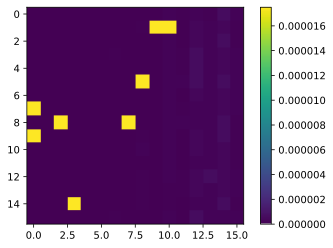

In [82]:
# plt.imshow(Gmap_all[0])
plt.imshow(Gmap_all[4])
plt.colorbar()

In [92]:
Vread = 0.2

Vgate = 5

Gmap_all = []

for ar in [0,1,2]:
    Gmap = []
    print(f'\n ar={ar}, ')
    for r in range(64):
        print(f'\n r={r}, ', end='')
        
        Grow = []
        for c in range(64):
            if c%5 ==0:
                print(f'c={c}', end='-')
            
            curr = a0.read_single(Vread=Vread, Vgate=Vgate, array=ar, row=r, col=c, gain=2)
            Grow.append( curr / Vread )
        Gmap.append(Grow)
    
    Gmap_all.append(Gmap)


 ar=0, 

 r=0, c=0-c=5-c=10-c=15-c=20-c=25-c=30-c=35-c=40-c=45-c=50-c=55-c=60-
 r=1, c=0-c=5-c=10-c=15-c=20-c=25-c=30-c=35-c=40-c=45-c=50-c=55-c=60-
 r=2, c=0-c=5-c=10-c=15-c=20-c=25-c=30-c=35-c=40-c=45-c=50-c=55-c=60-
 r=3, c=0-c=5-c=10-c=15-c=20-c=25-c=30-c=35-c=40-c=45-c=50-c=55-c=60-
 r=4, c=0-c=5-c=10-c=15-c=20-c=25-c=30-c=35-c=40-c=45-c=50-c=55-c=60-
 r=5, c=0-c=5-c=10-c=15-c=20-c=25-c=30-c=35-c=40-c=45-c=50-c=55-c=60-
 r=6, c=0-c=5-c=10-c=15-c=20-c=25-c=30-c=35-c=40-c=45-c=50-c=55-c=60-
 r=7, c=0-c=5-c=10-c=15-c=20-c=25-c=30-c=35-c=40-c=45-c=50-c=55-c=60-
 r=8, c=0-c=5-c=10-c=15-c=20-c=25-c=30-c=35-c=40-c=45-c=50-c=55-c=60-
 r=9, c=0-c=5-c=10-c=15-c=20-c=25-c=30-c=35-c=40-c=45-c=50-c=55-c=60-
 r=10, c=0-c=5-c=10-c=15-c=20-c=25-c=30-c=35-c=40-c=45-c=50-c=55-c=60-
 r=11, c=0-c=5-c=10-c=15-c=20-c=25-c=30-c=35-c=40-c=45-c=50-c=55-c=60-
 r=12, c=0-c=5-c=10-c=15-c=20-c=25-c=30-c=35-c=40-c=45-c=50-c=55-c=60-
 r=13, c=0-c=5-c=10-c=15-c=20-c=25-c=30-c=35-c=40-c=45-c=50-c=55-c=60-
 r=14,

In [93]:
from lib_data import *
save_workspace(vars(), note='all_gain2')

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), volt_in(<class 'numpy.ndarray'>), volt_out_list(<class 'list'>), addr_fifo(<class 'int'>), data(<class 'list'>), volt_out(<class 'list'>), n_adc(<class 'int'>), d(<class 'int'>), Vreads(<class 'numpy.ndarray'>), Vgates(<class 'list'>), volts_set(<class 'list'>), Vgate(<class 'int'>), volts(<class 'list'>), vread(<class 'numpy.float64'>), Vread(<class 'float'>), Gmap_all(<class 'list'>), ar(<class 'int'>), Gmap(<class 'list'>), r(<class 'int'>), Grow(<class 'list'>), c(<class 'int'>), curr(<class 'float'>), gain(<class 'int'>), to 20190804-213908-all_gain2.pkl
Saving In(<class 'list'>), volt_in(<class 'numpy.ndarray'>), volt_out_list(<class 'list'>), addr_fifo(<class 'int'>), data(<class 'list'>), volt_out(<class 'list'>), n_adc(<class 'int'>), d(<class 'int'>), Vreads(<class 'numpy.ndarray'>), Vgates(<class 'list'>), volts_set(<class 'list

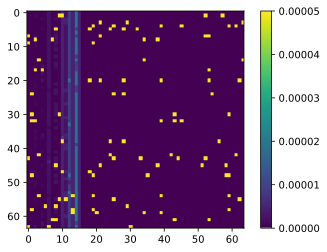

In [106]:
plt.imshow(Gmap_all[1])
plt.clim(0, 50e-6)
plt.colorbar()